In [1]:
# from google.colab import drive
# drive.mount('/content/drive/') 

# **Problem Description**

Netflix is all about connecting people to the movie they love. To help cutomes find those movies, they devloped world-class recommandation system **CinematchSM**. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies. Netflix use those predictions to make personal movie recommandations based on each customer's unique tastes. And while **Cinematch** is doing pretty well, it can always be made better.


Now there are a lot of interesting alternative approaches to how Cinematch works that netflix have not tried.Some are descibed in the literature, some are not. we are curious whether any of these can beat Cinematch by making better prediction. Because, if there are much better approachm it could make a big diffrence to our customers and our business 


# **Problem Statment**

Netflix provided a lot of anonymous rating data, and a prediction accuracy bar that is 10% better than what Cinematch can do on the same training dataset. (Accuracy is a measurement of how closely predicted ratings of movies match subsequent actual ratings.)

## **Real world/Business Objectives and constraints**


1.   Predict the rating that a user would give to a movie which is not yet rated

1.   Minimize the difference between predicted and actual rating(RMSE and MAPE)

2.   Some form of interpretability





Get the data from : https://www.kaggle.com/netflix-inc/netflix-prize-data/data

Data files :

combined_data_1.txt

combined_data_2.txt

combined_data_3.txt

combined_data_4.txt

movie_titles.csv

The first line of each file [combined_data_1.txt, combined_data_2.txt, combined_data_3.txt, combined_data_4.txt] contains the movie id followed by a colon. Each subsequent line in the file corresponds to a rating from a customer and its date in the following format:

CustomerID,Rating,Date

MovieIDs range from 1 to 17770 sequentially.
CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
Ratings are on a five star (integral) scale from 1 to 5.
Dates have the format YYYY-MM-DD.





### **Example Data point**

1:

1488844,3,2005-09-06

822109,5,2005-05-13

885013,4,2005-10-19

30878,4,2005-12-26

823519,3,2004-05-03

893988,3,2005-11-17

124105,4,2004-08-05

1248029,3,2004-04-22

1842128,4,2004-05-09

2238063,3,2005-05-11

1503895,4,2005-05-19

2207774,5,2005-06-06

2590061,3,2004-08-12

2442,3,2004-04-14

543865,4,2004-05-28

1209119,4,2004-03-23

804919,4,2004-06-10

1086807,3,2004-12-28


### **Type of Machine Learning Problem**

For a given movie and user we need to predict the rating would be given by him/her to the movie.

The given problem is a Recommendation problem.

It can also seen as a Regression problem.

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
#matplotlib.use('nbagg')

import matplotlib.pyplot as plt
#plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

# **Exploratory Data Analysis**

## **Preprocessing**

### **Converting / Merging whole data to required format: u_i, m_j, r_ij**

In [2]:
start = datetime.now()
if not os.path.isfile('data.csv'):
    data = open('data.csv', mode='w')
    row = list()
    files = ['combined_data_3.txt','combined_data_4.txt']#,'/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/combined_data_2.txt']#, '/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/combined_data_3.txt', '/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/combined_data_4.txt']

    for file in files:
        print('Reading rating from {}...'.format(file))
        with open(file) as f:
            for line in f:
                del row[:] #you don't have to do this
                line = line.strip()
                if line.endswith(':'):
                  #all below are rating for this movie, until another
                  movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')

    print('Done.\n')
    data.close()
    print('Time taken :',datetime.now() - start)

Reading rating from combined_data_3.txt...
Reading rating from combined_data_4.txt...
Done.

Time taken : 0:02:43.315062


In [4]:
print("Creating the dataframe from data.csv file...")
df = pd.read_csv('data.csv', sep=',',names = ['movie', 'user', 'rating', 'date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

#arranging the rating according to time
print('Sorting the datetime by date...')
df.sort_values(by='date', inplace=True)
print('Done..')

Creating the dataframe from data.csv file...
Done.

Sorting the datetime by date...
Done..


In [5]:
df.head(10)

,movie,user,rating,date
45181370,17064,510180,2,1999-11-11
19664881,12818,510180,2,1999-11-11
2845807,9798,510180,3,1999-11-11
49429494,17764,510180,5,1999-11-11
33271295,15057,510180,5,1999-11-11
17598291,12470,510180,2,1999-11-11
30861853,14660,510180,2,1999-11-11
773770,9392,510180,3,1999-11-11
38460478,15894,510180,3,1999-11-11
11197286,11313,510180,2,1999-11-11


In [6]:
df.shape

(49449152, 4)

In [7]:
df.describe()['rating']

count    4.944915e+07
mean     3.614743e+00
std      1.084964e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

**Checking for NaN Values**

In [8]:
# Just to make sure that all NAN containing rows are deleted..

print("Number of Nan values in our dataframe : ", sum(df.isnull().any()))

Number of Nan values in our dataframe :  0


**Removing Duplicates**

In [9]:
dup_bool = df.duplicated(['movie', 'user', 'rating'])
dups = sum(dup_bool) #by considering all columns..(including timestamp)
print("There are {} duplicate rating entries in the data...".format(dups))

There are 0 duplicate rating entries in the data...


**Basic Statistics(# of Rating, # of Users, # of Movies)**

In [10]:
print("Total Data")
print("-"*70)
print("\nTotal no. of rating : ",df.shape[0])
print("Total No. of Users : ", len(np.unique(df.user)))
print("Total No. of Movies : ", len(np.unique(df.movie)))

Total Data
----------------------------------------------------------------------

Total no. of rating :  49449152
Total No. of Users :  478796
Total No. of Movies :  8560


**Spliting data into Train and Test(80:20)**

In [11]:
if not os.path.isfile('train.csv'):
  #create the dataframe and store it in the disk for offline purpose...
  df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
  #creating the dataframe and store it in the disk for offline purpose...
  df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index = False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

**Basic statistic in Train data (# of Ratings # of Users and # of Movies)**

In [12]:
# movies = train_df.movie.value_counts()
# users = train_df.user.value_counts()
print("Training data")
print("-"*70)
print("\nTotal no of ratings : ",test_df.shape[0])
print("Total no of Users : ", len(np.unique(test_df.user)))
print("Total no. of movies : ", len(np.unique(test_df.movie)))

Training data
----------------------------------------------------------------------

Total no of ratings :  4810753
Total no of Users :  302727
Total no. of movies :  4497


**EDA On Train data**

In [13]:
def human(num, units = "M"):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3)+'K'
    elif units == 'm':
        return str(num/10**6)+'M'
    elif units == 'b':
        return str(num/10**9)+'B'


**Distribution of ratings**

In [172]:
import matplotlib.ticker as mticker
# import warnings
# warnings.filterwarnings("ignore")

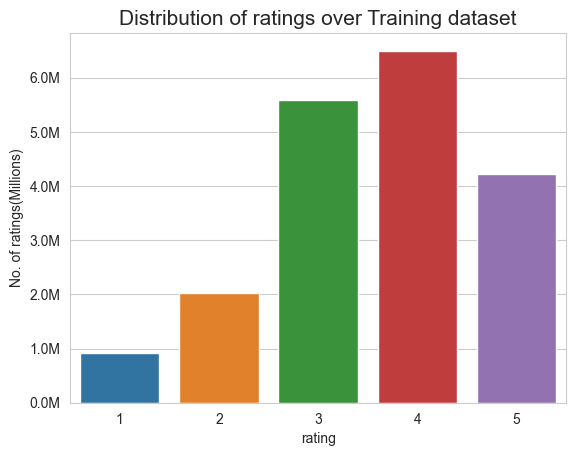

In [173]:
fig, ax = plt.subplots()
plt.title("Distribution of ratings over Training dataset", fontsize=15)
sns.countplot(x = train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel("No. of ratings(Millions)")
plt.show()

**Add a new column(Week day) to the data set for analysis**

In [15]:
# It is used to skip the warnings 'SettingWithCopyWarning'...
pd.options.mode.chained_assignment = None        #default = 'warn'
train_df['day_of_week'] = train_df.date.dt.day_name()
#df['day_of_week'] = df['mydate'].dt.day_name() 
train_df.head(20)



,movie,user,rating,date,day_of_week
0,1798,510180,5,1999-11-11,Thursday
1,2866,510180,3,1999-11-11,Thursday
2,3730,510180,4,1999-11-11,Thursday
3,3870,510180,2,1999-11-11,Thursday
4,1367,510180,5,1999-11-11,Thursday
5,2948,510180,3,1999-12-06,Monday
6,3421,510180,3,1999-12-06,Monday
7,2478,510180,3,1999-12-06,Monday
8,1615,122223,3,1999-12-08,Wednesday
9,2780,122223,3,1999-12-08,Wednesday


**Number of Ratings per month**

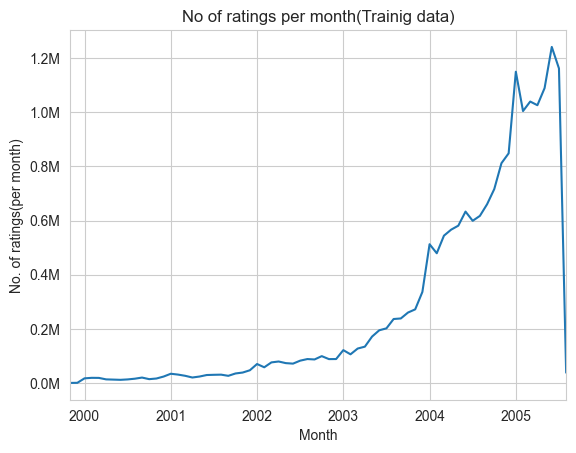

In [174]:
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month(Trainig data)')
plt.xlabel('Month')
plt.ylabel('No. of ratings(per month)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

**Analysis on the Ratings given by user**

In [17]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count()
no_of_rated_movies_per_user.head()

user
6     105
7     190
10     38
25      2
33      8
Name: rating, dtype: int64

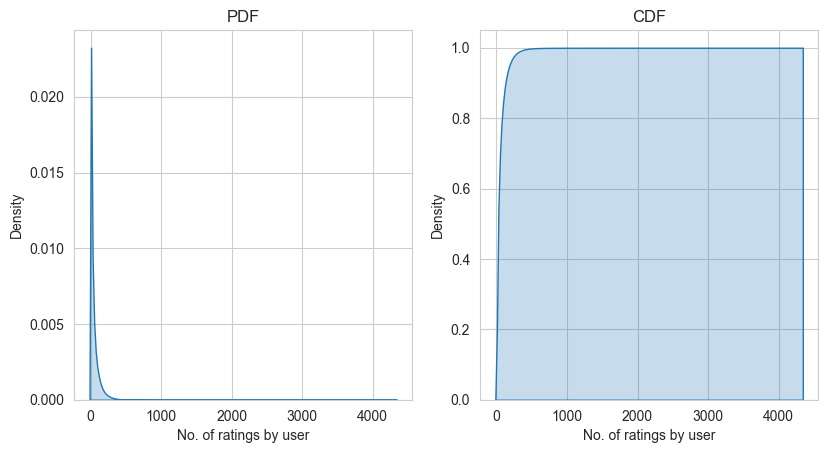

In [18]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, fill=True, ax=ax1)
plt.xlabel("No. of ratings by user")
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, fill=True, cumulative=True, ax=ax2)
plt.xlabel("No. of ratings by user")
plt.title('CDF')
plt.show()

In [19]:
no_of_rated_movies_per_user.describe()

count    389223.000000
mean         49.439553
std          71.463434
min           1.000000
25%           8.000000
50%          23.000000
75%          62.000000
max        4326.000000
Name: rating, dtype: float64

In [20]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0, 1.01, 0.01))

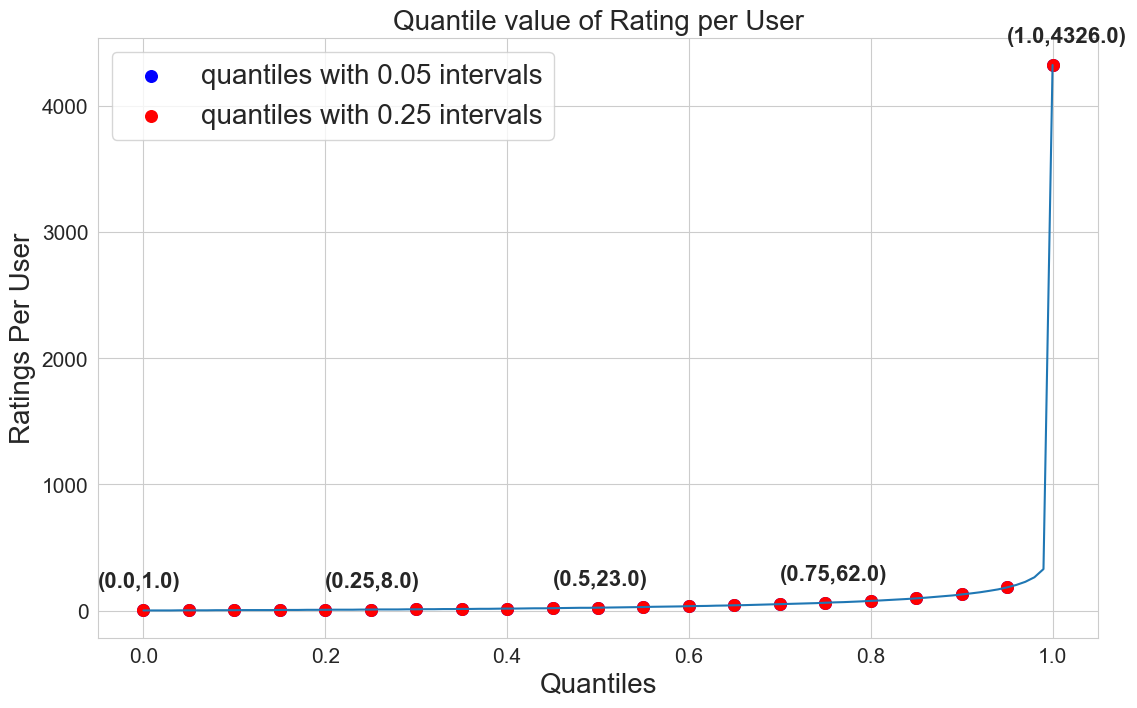

In [24]:
fig = plt.figure(figsize = (10, 6))
axes = fig.add_axes([0.1, 0.1, 1, 1])
axes.set_title("Quantile value of Rating per User", fontsize = 20)
axes.set_xlabel("Quantiles", fontsize = 20)
axes.set_ylabel("Ratings Per User", fontsize = 20)
axes.plot(quantiles)

plt.scatter(x = quantiles.index[::5], y=quantiles.values[::5], c='blue', s=70, label="quantiles with 0.05 intervals")

plt.scatter(x = quantiles.index[::5], y=quantiles.values[::5], c="red", s=70, label = "quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize = 20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):plt.annotate(text='({},{})'.format(x,y), xy = (x,y),fontweight
                                                                            ='bold', fontsize = 16, xytext=(x-0.05, y+180))

axes.tick_params(labelsize = 15)

In [25]:
quantiles[::5]

0.00       1.0
0.05       2.0
0.10       3.0
0.15       5.0
0.20       6.0
0.25       8.0
0.30      10.0
0.35      13.0
0.40      16.0
0.45      19.0
0.50      23.0
0.55      28.0
0.60      35.0
0.65      42.0
0.70      51.0
0.75      62.0
0.80      77.0
0.85      97.0
0.90     128.0
0.95     184.0
1.00    4326.0
Name: rating, dtype: float64

In [26]:
print("Total number of ratings below 75th percentile = "+str(sum(no_of_rated_movies_per_user.values<=133)))
print("Total number of ratings above 75th percentile = "+str(sum(no_of_rated_movies_per_user.values>133)))

Total number of ratings below 75th percentile = 353210
Total number of ratings above 75th percentile = 36013


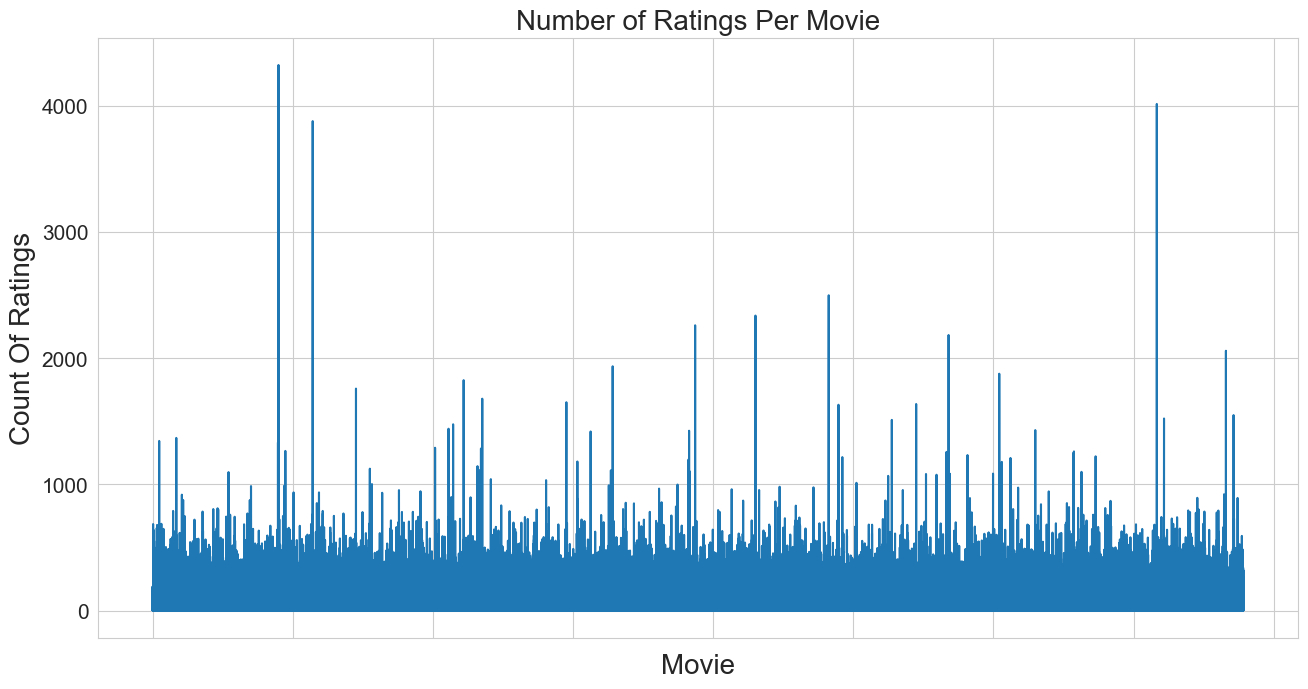

In [27]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize=20)
plt.ylabel("Count Of Ratings", fontsize=20)
plt.plot(no_of_rated_movies_per_user.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

**It is skewed nicely**

It clearly shows that there are some movies which are very popular and were rated by 90% users as comapared to other movies

Number of ratings on each day of the week

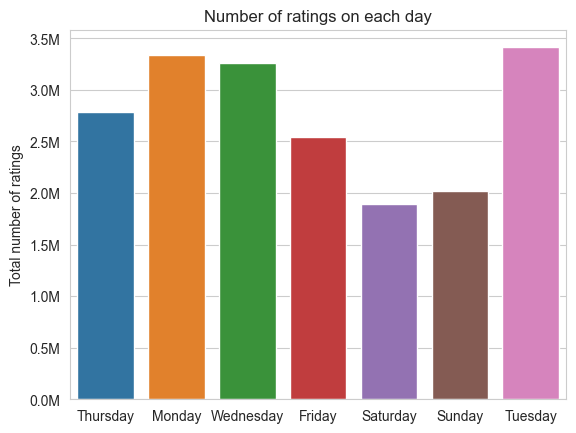

In [175]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data = train_df, ax = ax)
plt.title("Number of ratings on each day")
plt.ylabel('Total number of ratings')
plt.xlabel("")
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

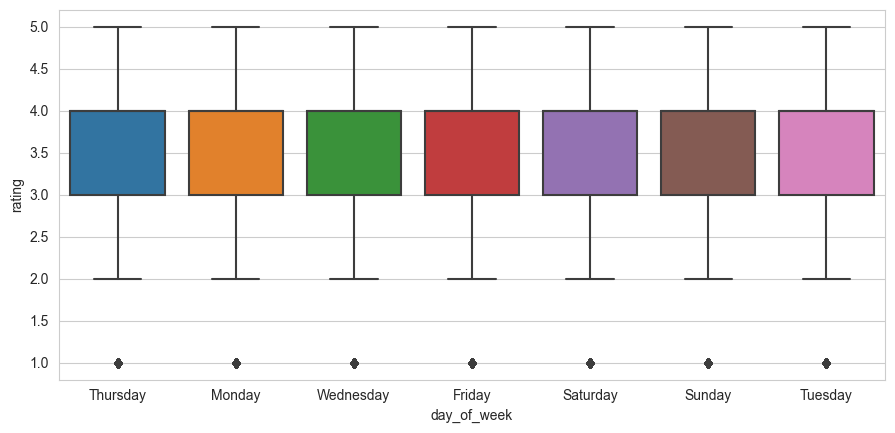

0:00:16.781615


In [29]:
start = datetime.now()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating', x='day_of_week', data=train_df)
plt.show()
print(datetime.now()-start)

In [30]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print('Average Ratings')
print("_"*30)
print(avg_week_df)
print("\n")

Average Ratings
______________________________
day_of_week
Friday       3.576426
Monday       3.573257
Saturday     3.585673
Sunday       3.588731
Thursday     3.577798
Tuesday      3.570347
Wednesday    3.578739
Name: rating, dtype: float64




## **Creating sparse matrix from data frame**

In [31]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
  print("It is present in your pwd, getting it from disk......")
  #just get it from the disk instead of computing it
  train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
  print("Done...")

else:
  print("We are creating sparse matrix from the dataframe.....")
  #create sparse matrix and store it after usages.
  #It should be in such a way that, Matrix[row, col] = data
  train_sparse_matrix = sparse.csr_matrix((train_df.rating.values,(train_df.user.values, train_df.movie.values)),)
  print("Done. It\'s shape is : (user, movie", train_sparse_matrix.shape)
  print("Saving it into disk for further usages...")
  sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
  print("Done.....\n")
  print(datetime.now()-start)

It is present in your pwd, getting it from disk......
Done...


### **The sparsity of train sparse matrix**

In [32]:
us, mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()
print("Sparsity of train matrix : {} % ".format((1-elem/(us*mv))*100))

Sparsity of train matrix : 99.83859831485766 % 


## **Creating sparse matrix from test data frame**

In [33]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
  print("It is present in your pwd, getting it from disk....")
  #just get it from the disk instead of computing it.
  test_sparse_matrix = sparse.load_npz("test_sparse_matrix.npz")
  print("Done....")
else:
  print("We are creating sparse matrix from the dataframe....")
  #create sparse_matrix and store it for after usages
  #It should be in such a way that, matrix[row, col] = data
  test_sparse_matrix = sparse.csr_matrix((test_df.rating.values,(test_df.user.values, test_df.movie.values)),)
  print("Done. It\'s shape is : (user, movie):", test_sparse_matrix.shape)
  print("Saving it into disk for further usages....")
  #save it into disk
  sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
  print('Done...\n')
print(datetime.now()-start)

It is present in your pwd, getting it from disk....
Done....
0:00:00.363442


### **The sparsity of test data matrix**

In [34]:
us, mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()
print("sparsity of Test matrix : {} % ".format((1-elem/(us*mv))*100))

sparsity of Test matrix : 99.95964957661752 % 


### **Finding Global Average of all movies ratings, Averages rating per user, and average rating per movie**

In [35]:
#get the averages in dictionary(key:user_id/movie_id, value:avg rating)
def get_average_rating(sparse_matrix, of_users):
  #average rating of user/axes
  ax = 1 if of_users else 0 #1-user axes, 0-Movie axes
  #".AI" is for converting column_matrix to 1-D numpy array
  sum_of_ratings = sparse_matrix.sum(axis=ax).A1
  #Boolean matrix of ratings(whether a user rated movie or not)
  is_rated = sparse_matrix != 0
  #no. of ratings that each user or movie
  no_of_ratings = is_rated.sum(axis=ax).A1
  #max_user and max_movie ids in sparse matrix
  u, m = sparse_matrix.shape
  #create a dictionary of users and their averages ratings..
  averages_ratings = { i :sum_of_ratings[i]/no_of_ratings[i] for i in range(u if of_users else m) if no_of_ratings[i] != 0}
  #return that dictionary of average rating
  return averages_ratings


## **Finding global average of all movie ratings**

In [36]:
train_averages = dict()
#get the global avetrage of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.577584765710522}

## **Finding average rating per users**

In [37]:
train_averages['user'] = get_average_rating(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 : ',train_averages['user'][10])



Average rating of user 10 :  3.263157894736842


## **Finding average rating per movie**

In [38]:
train_averages['movie'] = get_average_rating(train_sparse_matrix, of_users=False)
print('\nAverages rating of movie 15 :',train_averages['movie'][15])


Averages rating of movie 15 : 3.312741312741313


## **PDF's & CDF's of Avg ratings of users and movies(In Train data)**

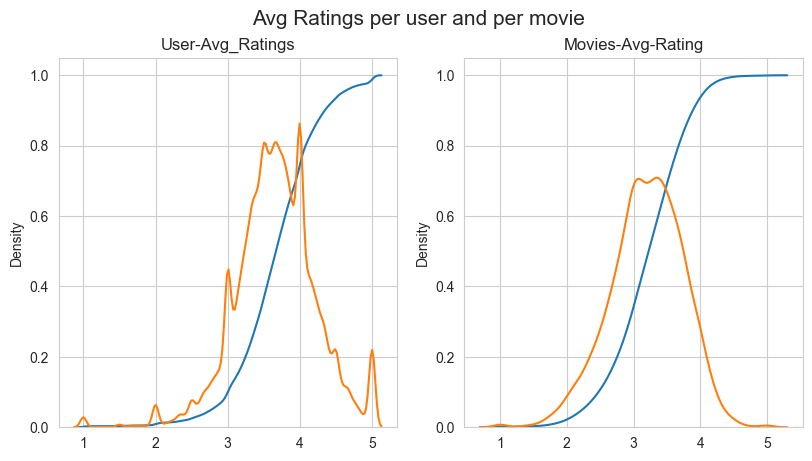

0:00:12.904799


In [180]:
start = datetime.now()
#draw pdfs for averages rating per user and average
fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle("Avg Ratings per user and per movie",fontsize=15)
ax1.set_title('User-Avg_Ratings')
#get the list average user ratings from the averages dictionary..
user_averages = [rat for rat in train_averages['user'].values()]
sns.distplot(user_averages, ax=ax1, hist=False,kde_kws=dict(cumulative=True),label='Cdf')
sns.distplot(user_averages, ax=ax1, hist=False,label='pdf')

ax2.set_title('Movies-Avg-Rating')
#get the list of movie_average_ratings from the dictionary..
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.distplot(movie_averages, ax=ax2, hist=False, kde_kws=dict(cumulative=True),label='pdf')
sns.distplot(movie_averages, ax=ax2, hist=False, label='Pdf')

plt.show()
print(datetime.now()-start)

### **Cold start Problem with users**

In [40]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users-users_train

print('\nTotal number of users : ',total_users)
print('\nNumber of Users in train data : ',users_train)
print("\nNumber of users that did not appear in train data : {}({} %)".format(new_users,np.round((new_users/total_users)*100, 2)))


Total number of users :  478796

Number of Users in train data :  389223

Number of users that did not appear in train data : 89573(18.71 %)


**Cold start problem with movies**

In [41]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies-movies_train

print('\nTotal number of movies : ',total_movies)
print('\nNumber of User in train data : ',movies_train)
print("\n No of movies that did not appear in train data : {}({} %)".format(new_movies, np.round((new_movies/total_movies)*100,2)))


Total number of movies :  8560

Number of User in train data :  4403

 No of movies that did not appear in train data : 4157(48.56 %)


## **Computing Similarity matrices**

**Computing user-user Similarity matrix**

1. Caculating user user Similarity_matrix is not very easy(unless you have huge Computing Power and lots of time) because of number of usersbeing lare


In [42]:
from sklearn.metrics.pairwise import cosine_similarity
def compute_user_similarity(sparse_matrix, compute_for_few=False, top=100, verbose=False,
                            verb_for_n_rows = 20,draw_time_taken = True):
  no_of_users, _ = sparse_matrix.shape
  #get the indices of non zero rows(users) from our sparse matrix
  row_ind, col_ind = sparse_matrix.nonzero()
  row_ind = sorted(set(row_ind))
  time_taken = list() #time taken forn finding similar users for an user...
  # we create row,cols and data list.., which can be used to create sparse matrices
  rows, cols,data = list(), list(), list()
  if verbose: print("Computing top",top,"similarities for each user...")
  start = datetime.now()
  tmp=0
  for row in row_ind[:top] if compute_for_few else row_ind:
    tmp += 1
    prev = datetime.now()

    #get the similarity row for this user with all other users
    sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
    #we will get only the 'top' most similar users and ignore rest of them
    top_sim_ind = sim.argsort()[-top:]
    top_sim_val = sim[top_sim_ind]
    
    #add them to our row, cols and data
    rows.extend([row]*top)
    cols.extend(top_sim_ind)
    data.extend(top_sim_val)
    time_taken.append(datetime.now().timestamp() - prev.timestamp())

    if verbose:
      if tmp%verb_for_n_rows == 0:
        print("computing done for {} users [time elased : {} ]".format(tmp, datetime.now()-start))


    # lets create sparse matrix out of these and return it
  if verbose: print("Creating sparse matrix from the computed similarities")

      #return rows, cols, data

  if draw_time_taken:
    plt.plot(time_taken, label = 'time taken for each user')
    plt.plot(np.cumsum(time_taken), label='Total time')
    plt.legend(loc='best')
    plt.xlabel('User')
    plt.ylabel('Time(seconds)')
    plt.show()
  return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken

Computing top 40 similarities for each user...
computing done for 20 users [time elased : 0:00:16.311968 ]
computing done for 40 users [time elased : 0:00:32.661809 ]
Creating sparse matrix from the computed similarities


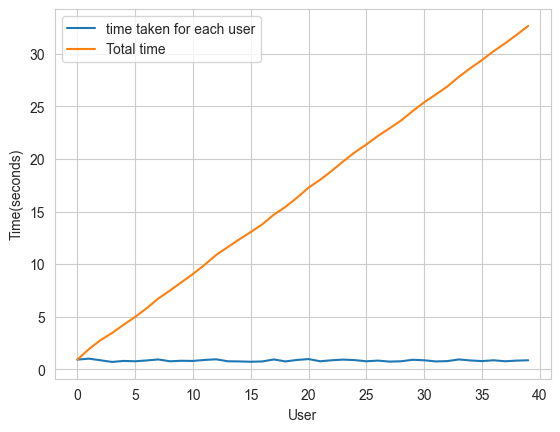

----------------------------------------------------------------------------------------------------
Time taken : 0:00:34.929188


In [43]:
# We are not going to run it on whole data it will gives us memory error or so we will try it on 100
start = datetime.now()
u_u_sim_sparse, _ = compute_user_similarity(train_sparse_matrix, compute_for_few=True, top = 40,verbose=True)
print("-"*100)
print("Time taken :",datetime.now()-start)

Trying with reduced dimensions (Using TruncatedSVD for dimensionality reduction of user vector)
We have 405,041 users in out training set and computing similarities between them..( 17K dimensional vector..) is time consuming..
From above plot, It took roughly 8.88 sec for computing simlilar users for one user
We have 405,041 users with us in training set.
${ 405041 \times 8.88 = 3596764.08  \sec } =  59946.068 \min = 999.101133333 \text{ hours}
= 41.629213889 \text{ days}...$

Even if we run on 4 cores parallelly (a typical system now a days), It will still take almost 10 and 1/2 days.
IDEA: Instead, we will try to reduce the dimentsions using SVD, so that it might speed up the process...



In [44]:
from datetime import datetime
from sklearn.decomposition import TruncatedSVD
start = datetime.now()
#initilize the algorithm with some parameter
#All of them are default except n_component. n_iter is for randomized SVD solver
netflix_svd = TruncatedSVD(n_components=40, algorithm='randomized', random_state=15)
trunc_svd = netflix_svd.fit_transform(train_sparse_matrix)
print(datetime.now()-start)

0:00:54.908616



Here,

$\sum \longleftarrow$ (netflix_svd.singular_values_ )

$\bigvee^T \longleftarrow$ (netflix_svd.components_)

$\bigcup$ is not returned. instead Projection_of_X onto the new vectorspace is returned.

It uses randomized svd internally, which returns All 3 of them saperately. Use that instead.

In [45]:
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)


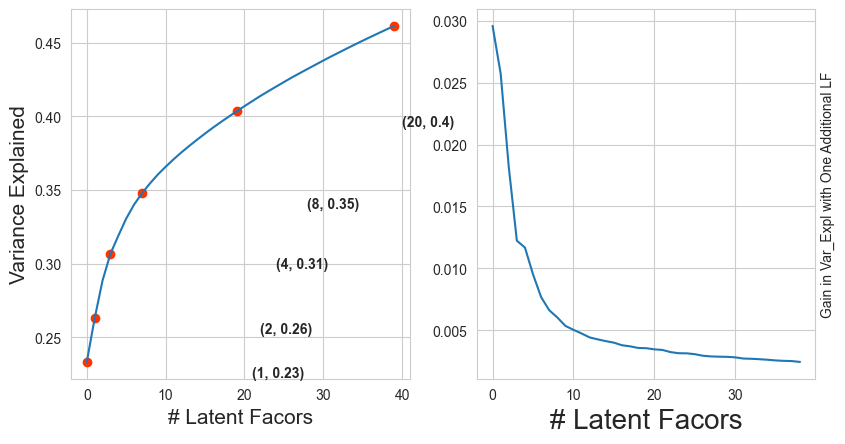

In [46]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))

ax1.set_ylabel("Variance Explained", fontsize=15)
ax1.set_xlabel("# Latent Facors", fontsize=15)
ax1.plot(expl_var)
# annote some (latentfactors, expl_var) to make it clear
ind = [1, 2,4,8,20,40]
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c='#ff3300')
for i in ind:
    ax1.annotate(text ="({}, {})".format(i,  np.round(expl_var[i-1], 2)), xy=(i-1, expl_var[i-1]),
                xytext = ( i+20, expl_var[i-1] - 0.01), fontweight='bold')

change_in_expl_var = [expl_var[i+1] - expl_var[i] for i in range(len(expl_var)-1)]
ax2.plot(change_in_expl_var)



ax2.set_ylabel("Gain in Var_Expl with One Additional LF", fontsize=10)
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("# Latent Facors", fontsize=20)

plt.show()

In [47]:
for i in ind:
  print("({}, {})".format(i, np.round(expl_var[i-1], 2)))

(1, 0.23)
(2, 0.26)
(4, 0.31)
(8, 0.35)
(20, 0.4)
(40, 0.46)


In [48]:
#lets project our original U_M matrix into 40 Dimentional space
start = datetime.now()
trunc_matrix = train_sparse_matrix.dot(netflix_svd.components_.T)
print(datetime.now()-start)

0:00:00.528103


In [49]:
type(trunc_matrix), trunc_matrix.shape

(numpy.ndarray, (2649430, 40))

### **Lets Convert this to actual sparse matrix and store it for future purpose**

In [50]:
if not os.path.isfile("trunc_sparse_matrix.npz"):
#create that sparse matrix
  trunc_sparse_matrix = sparse.csr_matrix(trunc_matrix)
#save this truncated sparse matrix for later usage
  sparse.save_npz('trunc_sparse_matrix', trunc_sparse_matrix)
else:
  trunc_sparse_matrix = sparse.load_npz('trunc_sparse_matrix.npz')


In [51]:
trunc_sparse_matrix.shape

(2649430, 40)

Computing top 50 similarities for each user...
computing done for 10 users [time elased : 0:00:07.515086 ]
computing done for 20 users [time elased : 0:00:14.304512 ]
computing done for 30 users [time elased : 0:00:20.992225 ]
computing done for 40 users [time elased : 0:00:27.723077 ]
computing done for 50 users [time elased : 0:00:34.411385 ]
Creating sparse matrix from the computed similarities


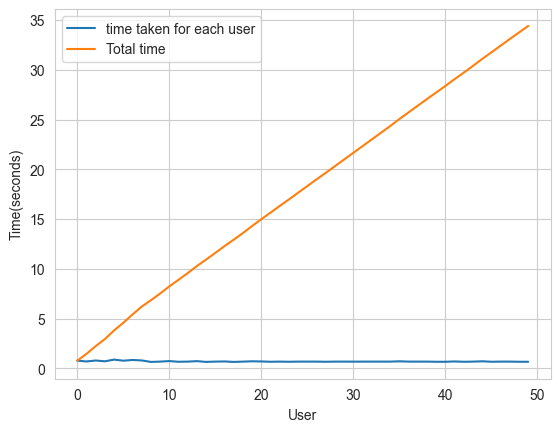

__________________________________________________
time: 0:00:36.324851


In [52]:
#getting memory error
start = datetime.now()
trunc_u_u_sim_matrix, _ = compute_user_similarity(trunc_sparse_matrix, compute_for_few = True, top=50, verbose=True, verb_for_n_rows=10)
print("_"*50)
print("time:",datetime.now()-start)

**Computing Movies-Movies Similarity matrix**





In [56]:
start = datetime.now()
if not os.path.isfile("movie_movie_sim_sparse.npz"):
    print("It seems you don't have that file. Computing movie_movie similarity..")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X = train_sparse_matrix.T, dense_output=False)
    print("Done...")
    #store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again...")
    sparse.save_npz("movie_movie_sim_sparse.npz",m_m_sim_sparse)
    print("Done...")
else:
    print("It is there, we will get it.")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done...")

print(datetime.now() - start)

It seems you don't have that file. Computing movie_movie similarity..
Done...
Saving it to disk without the need of re-computing it again...
Done...
0:00:32.905473


In [57]:
m_m_sim_sparse.shape

(4500, 4500)

**Even though we have similarity measure of each movie, with all other movies, we generally don't care much about least similar movies.** 

Most of the times, only top_xxx similar items matters. It may be 10 or 100.

We take only those top similar movie rating and store them in a saperate dictionary



In [58]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

In [59]:
start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
  #get the top similar movies and store them in the dictionary
  sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
  similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)

#just testing similar movies for movie_15
similar_movies[15]

0:00:01.704194


array([4424, 3755,  590, 3973, 1720, 2818, 4095, 3162, 2280, 2450, 2534,
       1072, 1416, 3338,  376,  598, 2187, 1942, 2716,  565, 1690, 4376,
        847, 1510, 2429, 3706, 1030, 2399, 4486, 2879, 4467, 3502, 2107,
       1391,  882,  509, 3726, 2215, 2637, 4037, 3580, 1493, 3602,  610,
        791, 2764,   31, 3511,  218, 3329, 1696, 2636, 1335,   61, 4326,
       1149, 1184, 4175, 4276, 2859, 2827, 1453, 1177,  280, 1874,  772,
       2219, 3396,  327, 3741, 3016,  914,  714,  679, 2545, 3616, 1647,
       2061, 3294, 1494, 2902, 1930, 4163, 3940, 1575, 4079,  756, 4090,
       1351, 4223, 3941, 3279, 2774, 4006,  917,  277, 2419, 2761, 2624,
       1249], dtype=int64)

**Finding most similar movies using similarity matrix**

Does Similarity really work as the way we expected?

Lets pick some random movie and check for its similar movies..

In [60]:
# First let's load the movie details into soe dataframe..
# movie details are in 'netflix/movie_titles.csv'

movie_titles = pd.read_csv("movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'],index_col = 'movie_id', verbose=True,
                      encoding = "ISO-8859-1")


Tokenization took: 12.01 ms
Type conversion took: 7.00 ms
Parser memory cleanup took: 0.00 ms


In [61]:
movie_titles.head()

,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [62]:
mv_id = 67

print("\nMovie----------->",movie_titles.loc[mv_id].values[1])
print("\nIt has {} Ratings from users.".format(train_sparse_matrix[:, mv_id].getnnz()))
print("\nWe have {} movies which are similar to this and we will get only top most.".format(m_m_sim_sparse[:,mv_id].getnnz()))
print()


Movie-----------> Vampire Journals

It has 268 Ratings from users.

We have 4369 movies which are similar to this and we will get only top most.



In [63]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()
similar_indices = similarities.argsort()[::-1][1:]
similarities[similar_indices]
similar_indices = similarities.argsort()[::-1][1:] # It will sort and reverse the array and ignore its similarity(i.e., 1)
# and return its indices(movie_ids)

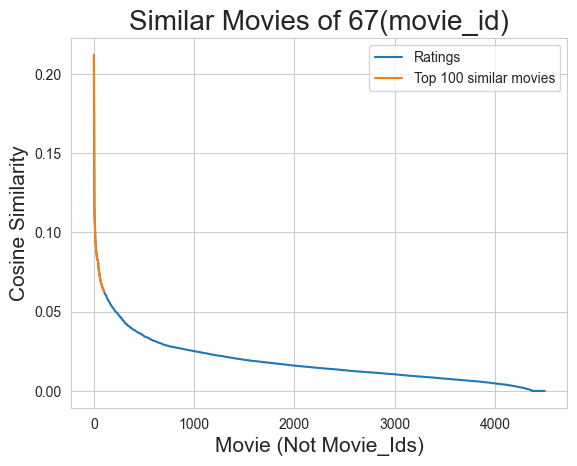

In [64]:
plt.plot(similarities[similar_indices], label = "Ratings")
plt.plot(similarities[similar_indices[:100]], label = "Top 100 similar movies")
plt.title("Similar Movies of {}(movie_id)".format(mv_id), fontsize = 20)
plt.xlabel("Movie (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity", fontsize = 15)
plt.legend()
plt.show()

In [65]:
movie_titles.loc[similar_indices[:10]]

,year_of_release,title
movie_id,,
323,1999.0,Modern Vampires
4044,1998.0,Subspecies 4: Bloodstorm
1688,1993.0,To Sleep With a Vampire
1900,1997.0,Club Vampire
2004,2001.0,She Creature
415,2002.0,Reign in Darkness
3496,1998.0,Vampires
938,2002.0,Scarecrow
2948,1998.0,Razor Blade Smile


**Machine Learning Models**

In [66]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
  """It will get it from the 'path' if it is present or it will create and store the sampled sparse matrix in the path specified."""
   #get(row, col) and (rating) tuple from sparse matrix.
  row_ind, col_ind, ratings = sparse.find(sparse_matrix)
  users = np.unique(row_ind)
  movies = np.unique(col_ind)

  print("Original Matrix : (users, movies) => ({} {})".format(len(users), len(movies)))
  print("Original Matrix : Ratings -- {}\n".format(len(ratings)))
   # It just to make sure to get same sample everytime we run this program everytime
   # and pick without replacement
  np.random.seed(15)
  sample_users = np.random.choice(users, no_users, replace = False)
  sample_movies = np.random.choice(movies, no_movies, replace=False)

   #get the boolean mask or these sampled items in original row/col_inds
  mask = np.logical_and(np.isin(row_ind, sample_users), np.isin(col_ind, sample_movies))

  sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                            shape=(max(sample_users)+1, max(sample_movies)+1))
   

  if verbose:
    print("Sampled Matrix : (Users, movies) => ({} {})".format(len(sample_users), len(sample_movies)))
    print("Sampled Matrix : Ratings => ".format(ratings[mask].shape[0]))
    print("Saving it into disk for further usages.")
     #save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
      print("Done..\n")
    return sample_sparse_matrix

### **Sampling Data**

**Build sample train data from the train data**

In [67]:
#train_sparse_matrix = sparse.load_npz("train_sparse_matrix.npz")
#test_sparse_matrix = sparse.load_npz("test_sparse_matrix.npz")
#above are the matrix for all the users and movies
#train_sparse_matrix.shape

In [68]:
# As we know train_sparse_matrix contains matrix for user and movies lets take user and movies from it
start = datetime.now()
path = "sample_train_sparse_matrix.npz"
if os.path.isfile(path):
  print("It is present in your pwd, getting it from disk...")
  # just get it from the disk instead of computing it
  sample_train_sparse_matrix = sparse.load_npz(path)
  print("Done...")
else:
  # get 10k users and 1k movies from available data
  sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=10000, no_movies=1000,path = path)
print(datetime.now() - start)

It is present in your pwd, getting it from disk...
Done...
0:00:00.059864


**Build sample test data from the test data**

In [69]:
start = datetime.now()

path = "sample_test_sparse_matrix.npz"
if os.path.isfile(path):
  print("It is present in your pwd, getting it from disk...")
  # just get it from the disk instead of computing it
  sample_test_sparse_matrix = sparse.load_npz(path)
  print("Done..")
else:
  #get 5k users and 500 movies from available data
  sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=5000, no_movies=500,path = path)
print(datetime.now() - start)

It is present in your pwd, getting it from disk...
Done..
0:00:00.039002


**Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie(from sampled train)**

In [70]:
sample_train_averages = dict()

**Finding Global Averages of all movie ratings**

In [71]:
# get the global average of ratings in our train set
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages["global"] = global_average
sample_train_averages

{'global': 3.603744628606507}

**Finding Average rating per User**

In [72]:
sample_train_averages['user'] = get_average_rating(sample_train_sparse_matrix, of_users = True)
print('\nAverage rating of user 195 =',train_averages['user'][195])


Average rating of user 195 = 3.673076923076923


**Finding Average Rating per Movie**

In [73]:
sample_train_averages['movie'] = get_average_rating(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 150 :',sample_train_averages['movie'][150])


 AVerage rating of movie 150 : 2.1666666666666665


**Featurizing data**

In [74]:
print("\nNo of ratings in our Sampled train matrix = {}\n".format(sample_train_sparse_matrix.count_nonzero()))
print("\nNo of ratings in our Sampled test matrix = {}\n".format(sample_test_sparse_matrix.count_nonzero()))


No of ratings in our Sampled train matrix = 127062


No of ratings in our Sampled test matrix = 10988



**Featuring data for regression**

**Featurinzing train data**

In [75]:
#get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [76]:
sample_train_ratings.shape

(127062,)

In [79]:
print(sample_train_users.shape, sample_train_movies.shape, sample_train_ratings.shape)

(127062,) (127062,) (127062,)


In [90]:
############################################################
# It took me almost 26 hours to prepare this train dataset on my pc.#
############################################################
start = datetime.now()
if os.path.isfile('reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

preparing 127062 tuples for the dataset..

Done for 10000 rows----- 0:51:57.662134
Done for 20000 rows----- 1:38:20.050545
Done for 30000 rows----- 2:26:48.633452
Done for 40000 rows----- 3:14:31.230030
Done for 50000 rows----- 3:59:24.778621
Done for 60000 rows----- 4:42:14.839229
Done for 70000 rows----- 5:25:14.096176
Done for 80000 rows----- 6:08:15.905111
Done for 90000 rows----- 6:51:09.239262
Done for 100000 rows----- 7:34:03.456326
Done for 110000 rows----- 8:17:01.383687
Done for 120000 rows----- 8:59:42.703759
9:29:57.369249


**GAvg :** Average rating of all the ratings

**Similar users rating of this movie:** sur1, sur2, sur3, sur4, sur5(top 5 similar users who rated that movie)

**Similar movies  rated by this user:** smr1, smr2, smr3, smr4, smr5(top 5 similar movies rated by this movie)

**UAvg:** User's Average rating

**MAvg** Average rating of this movie

**Rating** Rating of this movie by this user

In [91]:
reg_train = pd.read_csv("reg_train.csv",
                        names = ['user', 'movie','GAvg','sur1','sur2','sur3','sur4','sur5','smr1',
                                 'smr2','smr3','smr4','smr5','UAvg','MAvg','rating'], header=None)
reg_train.head(10)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,1117050,15,3.603745,4.0,3.0,2.0,1.0,1.0,4.0,4.0,4.0,2.0,4.0,3.222222,2.250000,2
1,1292631,15,3.603745,1.0,1.0,2.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0,2.313131,2.250000,1
2,1550619,15,3.603745,4.0,2.0,3.0,2.0,1.0,4.0,4.0,4.0,4.0,4.0,4.000000,2.250000,4
3,1719753,15,3.603745,3.0,4.0,1.0,1.0,2.0,5.0,5.0,4.0,5.0,4.0,3.785714,2.250000,2
4,1830763,15,3.603745,1.0,3.0,1.0,2.0,2.0,3.0,3.0,3.0,4.0,4.0,2.978022,2.250000,1
5,1902838,15,3.603745,1.0,1.0,3.0,2.0,4.0,3.0,3.0,4.0,3.0,3.0,2.145923,2.250000,1
6,2247936,15,3.603745,4.0,2.0,1.0,3.0,1.0,4.0,3.0,3.0,3.0,4.0,3.545455,2.250000,4
7,2441503,15,3.603745,1.0,2.0,1.0,1.0,4.0,3.0,4.0,4.0,4.0,4.0,3.384615,2.250000,3
8,117959,24,3.603745,3.0,3.0,3.0,3.0,3.0,3.0,5.0,5.0,5.0,5.0,4.725806,2.826087,5
9,133289,24,3.603745,3.0,3.0,4.0,3.0,5.0,3.0,4.0,4.0,3.0,5.0,4.000000,2.826087,3


**Featurizing test data**

In [92]:
#get users, movies, and rating from the sampled Test
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [93]:
sample_train_averages['global']

3.603744628606507

In [94]:

if os.path.isfile('reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)   

preparing 10988 tuples for the dataset..

Done for 1000 rows----- 9:34:09.264583
Done for 2000 rows----- 9:38:22.558972
Done for 3000 rows----- 9:42:34.868138
Done for 4000 rows----- 9:46:46.849898
Done for 5000 rows----- 9:51:00.491026
Done for 6000 rows----- 9:55:11.366332
Done for 7000 rows----- 9:59:22.945109
Done for 8000 rows----- 10:03:36.539375
Done for 9000 rows----- 10:07:47.704528
Done for 10000 rows----- 10:12:01.163794
 10:16:16.884892


## **Reading from the file to make a dataframe**

In [95]:

reg_test_df = pd.read_csv('reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(10)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,760104,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5
1,777147,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5
2,1451564,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5
3,1496376,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,1
4,1748471,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,5
5,1934002,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,1
6,1934110,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,1
7,2189335,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,4
8,2411773,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3
9,128259,13,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,4


In [102]:
#!pip install surprise

## **Transforming data for Surprise models**

In [103]:
from surprise import Reader, Dataset

## **Transforming train data**

. We can't give raw data(movie, user, rating) to train the model in Surprise    library.

. They have a seprate format for train and test data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc, in Surprise.

. We can form the trainset from a file, or from a pandas DataFrame.

**Surprise Libraray**
https://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py

In [104]:
# It is to specify how to read the datafram
reader = Reader(rating_scale=(1, 5))

# create the traindata from the dataframe
train_data = Dataset.load_from_df(reg_train[['user', 'user', 'rating']], reader)
#Build the trainset from traindata, it is of dataset format from surprise libraray.
trainset = train_data.build_full_trainset()

### **Transformin test data**

. Testset is just a list of (user, movie, rating) tuples.(Order in the tuple is important

In [105]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(760104, 5, 5), (777147, 5, 5), (1451564, 5, 5)]

## **Machine Learning Models**

. Global dictionary that stores RMSE and MAPE for all the models.

   . It stores the metrics in a dictionary of dictionaries

   **Keys :** model name(string)

   **Value :** dict(key : metric, value: value)

In [106]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

**Utility functions for running regression models**

In [107]:
#To get rmse and mape given actual and predicted ratings.

def get_error_metrics(y_true, y_pred):
  rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
  mape = np.mean(np.abs((y_true - y_pred)/y_true))*100

  return rmse, mape

def run_xgboost(algo, x_train, y_train, x_test, y_test, verbose = True):
    #it will return train and test results

    #dictionaries to store train and test results.

    train_results = dict()
    test_results = dict()

    #fit the model
    print("Training the model...")
    start = datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print("Done. Time taken : {}\n".format(datetime.now() - start))
    print("Done\n")

    #from the trained model, get the predictions..
    print("Evaluating the model with train data...")
    start = datetime.now()
    y_train_pred = algo.predict(x_train)

    #get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)

    #Store the results in train_results dictionary.
    train_results = {'rmse' : rmse_train,
                     "mape" : mape_train,
                     'predictions' : y_train_pred        
    }

    #get the test data predictions and compute rmse and mape
    print("Evaluating test data.")
    y_test_pred = algo.predict(x_test)
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)

    #store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape': mape_test,
                    'predictions': y_test_pred}

    if verbose:
      print("\nTest Data")
      print('-'*50)
      print('RMSE : ', rmse_test)
      print("MAPE : ", mape_test)
    #return these train and test results.
    return train_results, test_results

**Utility functions for surprise modes**

In [108]:
#it is just to make sure taht all of our algorithms should produce same results. Everytime they run

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

#get (actual_list, predicted_list) rating given list of predictions (prediction is a class in surprise)

def get_ratings(predictions):
  actual = np.array([pred.r_ui for pred in predictions])
  pred = np.array([pred.est for pred in predictions])
  return actual, pred


# get 'RMSE' and "MAPE", given list of prediction objects

def get_errors(predictions):
  actual, pred = get_ratings(predictions)
  rmse = np.sqrt(np.mean((pred - actual)**2))
  mape = np.mean(np.abs(pred - actual)/actual)

  return rmse, mape*100

# It will return predicted ratings, rmse and mape of both train and test data

def run_surprise(algo, trainset, testset, verbose=True):
  #return train dict, test_dict. Each of them have 3 key-value pairs, which specify RMSE,
  # MAPE and predicted ratings

  start = datetime.now()
  # dictionaries taht stores metrices for train and test
  train = dict()
  test = dict()

  # train the algorithm with the trainset

  st = datetime.now()
  print("Training the model...")
  algo.fit(trainset)  
  print("Don. time taken : {}\n".format(datetime.now() - st))

  #Evaluating train data
  st = datetime.now()
  print("Evaluating the model with train data...")
  #get the train predictions(list of prediction class inside surprise)

  train_preds = algo.test(trainset.build_testset())
  #get predicted ratings from the train predictions
  train_actual_ratings, train_pred_ratings = get_ratings(train_preds)

  #get RMSE and MAPE from the train predictions
  train_rmse, train_mape = get_errors(train_preds)
  print("time taken : {}".format(datetime.now() - st))
  
  if verbose:
    print('-'*20)
    print('Train Data')
    print('-'*20)
    print('RMSE : {}\n\nMAPE : {}\n'.format(train_rmse, train_mape))

    #store them in the train dictionary
  if verbose:
    print('Adding train results in the dictionary.')
  train['rmse'] = train_rmse
  train['mape'] = train_mape
  train['predictions'] = train_pred_ratings

  #Evaluating test data
  st = datetime.now()
  print('\nEvaluating for test data.')
  #get the predictions(list of prediction classes) of test data
  test_preds = algo.test(testset)
  #get the predicted ratings from the list of predictions

  test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
  # get error metrics from the predicted and actual ratings

  test_rmse, test_mape = get_errors(test_preds)
  print('Time taken : {}'.format(datetime.now() - st))

  if verbose:
    print('-'*20)
    print('Test Data')
    print('-'*20)
    print('RMSE : {}\n\nMAPE : {}\n'.format(test_rmse, test_mape))

  #store them in test dictionary
  if verbose:
    print('Storing the test results in test dictionary.')
  test['rmse'] = test_rmse
  test['mape'] = test_mape
  test['predictions'] = test_pred_ratings
  print('\n'+"-"*50)
  print('Toatl time taken to run this algorithm : ', datetime.now() - start)
  return train, test

### **XGBoost with initial 13 features**

In [109]:
import xgboost as xgb
from scipy.stats import randint as sp_randint
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

TUning parameter: 

Time taken to tune : 0:08:03.672772

Training the model...
Done. Time taken : 0:00:50.052512

Done

Evaluating the model with train data...
Evaluating test data.

Test Data
--------------------------------------------------
RMSE :  1.1268747969899944
MAPE :  30.784920452669134


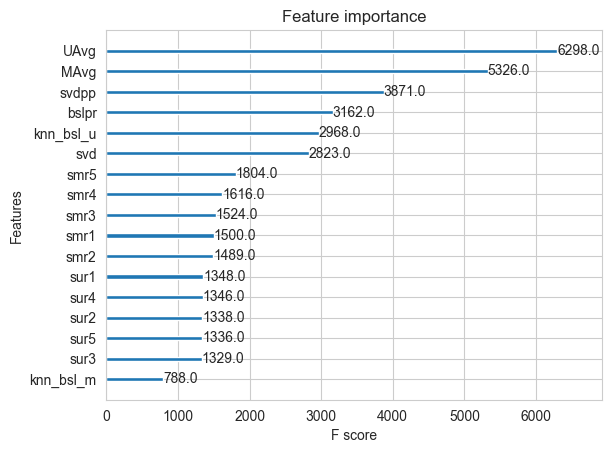

In [182]:
#prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

#prepare test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

#Hyperparameter tuning

param = {'learning_rate' : stats.uniform(0.01, 0.2),
         'n_estimators' : sp_randint(100, 1000),
         'max_depth' : sp_randint(1, 10),
         'min_child_weight' : sp_randint(1,8),
         'gamma': stats.uniform(0, 0.02),
         'subsample':stats.uniform(0.6, 0.4),
         'reg_alpha' :sp_randint(0, 200),
         'reg_lambda':stats.uniform(0, 200),
         'colsample_bytree' : stats.uniform(0.6, 0.3)
         }

#initialize our first xgboost model
xgbreg = xgb.XGBRegressor(verbosity=0, n_jobs=-1, random_state=15)
start = datetime.now()
print("TUning parameter: \n")
xgb_best = RandomizedSearchCV(xgbreg, param_distributions=param,refit=False, scoring='neg_mean_squared_error',
                              cv = 3, n_jobs = -1)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_
first_xgb = xgbreg.set_params(**best_para)

print("Time taken to tune : {}\n".format(datetime.now() - start))

train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

#store the results in models evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

### **Surprise Baseline Model**

In [183]:
from surprise import BaselineOnly

### **Predicting_rating : (baseline prediction)**

 http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly 

 image.png

 mu - Average of all rating in training data

 
 bu - User bias


 bi - item bias(movie biases)

### **Optimization function(Least Square Problem)**

http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration 


image.png

In [184]:
#options are to specify., how to compute those user and item biases

bsl_options = {'method' : 'sgd',
               'learninig_rate' : .001
    
}

bsl_algo = BaselineOnly(bsl_options = bsl_options)
#it will return train and test results

bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)

#just stores these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Don. time taken : 0:00:01.676960

Evaluating the model with train data...
time taken : 0:00:03.872248
--------------------
Train Data
--------------------
RMSE : 0.9646013829597728

MAPE : 30.000874371393454

Adding train results in the dictionary.

Evaluating for test data.
Time taken : 0:00:00.181181
--------------------
Test Data
--------------------
RMSE : 1.0556728510704523

MAPE : 32.174806516290474

Storing the test results in test dictionary.

--------------------------------------------------
Toatl time taken to run this algorithm :  0:00:05.730389


## **XGBoost with initial 13 features and Surprise Baseline Predictor**

**Updating Train Data**

In [185]:
#add our baseline_predicted value as our feature
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,1117050,15,3.603745,4.0,3.0,2.0,1.0,1.0,4.0,4.0,...,2.0,4.0,3.222222,2.25,2,3.290466,3.222222,3.222222,3.243475,3.259639
1,1292631,15,3.603745,1.0,1.0,2.0,3.0,4.0,3.0,4.0,...,3.0,3.0,2.313131,2.25,1,3.290466,3.222222,3.222222,3.243475,3.259639
2,1550619,15,3.603745,4.0,2.0,3.0,2.0,1.0,4.0,4.0,...,4.0,4.0,4.000000,2.25,4,3.290466,3.222222,3.222222,3.243475,3.259639
3,1719753,15,3.603745,3.0,4.0,1.0,1.0,2.0,5.0,5.0,...,5.0,4.0,3.785714,2.25,2,3.290466,3.222222,3.222222,3.243475,3.259639
4,1830763,15,3.603745,1.0,3.0,1.0,2.0,2.0,3.0,3.0,...,4.0,4.0,2.978022,2.25,1,3.290466,3.222222,3.222222,3.243475,3.259639


**Updating Test Data**

In [186]:
# add that baseline predicted ratings with surprise to the test data as well
reg_test_df['bslpr'] = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,760104,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,...,3.603745,3.603745,3.603745,3.603745,5,3.603745,3.603745,3.603745,3.603745,3.603745
1,777147,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,...,3.603745,3.603745,3.603745,3.603745,5,3.603745,3.603745,3.603745,3.603745,3.603745
2,1451564,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,...,3.603745,3.603745,3.603745,3.603745,5,3.603745,3.603745,3.603745,3.603745,3.603745
3,1496376,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,...,3.603745,3.603745,3.603745,3.603745,1,3.603745,3.603745,3.603745,3.603745,3.603745
4,1748471,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,...,3.603745,3.603745,3.603745,3.603745,5,3.603745,3.603745,3.603745,3.603745,3.603745


Tuning parameters.

Time taken to tune : 0:04:06.294640

Training the model...
Done. Time taken : 0:00:10.135625

Done

Evaluating the model with train data...
Evaluating test data.

Test Data
--------------------------------------------------
RMSE :  1.1300096334443221
MAPE :  30.793880179222455


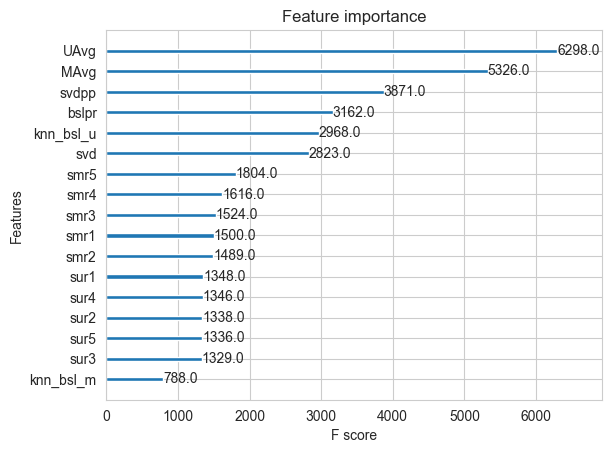

In [187]:
#prepare train data

x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

#preparing test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']


params = {'learning_rate' : stats.uniform(0.01, 0.2),
          'n_estimators':sp_randint(100,1000),
          'max_depth': sp_randint(1, 10),
          'min_child_weight':sp_randint(1, 8),
          'gamma' : stats.uniform(0, 0.02),
          'subsample': stats.uniform(0.6,0.4),
          'reg_alpha' : sp_randint(0, 200),
          'reg_lambda': stats.uniform(0, 200),
          'colsample_bytree' : stats.uniform(0.6, 0.3)
}

#initialize xgboost model.
xgbreg = xgb.XGBRegressor(silent=True, n_jobs=-1, random_stats=15)
start = datetime.now()
print('Tuning parameters.\n')
xgb_best = RandomizedSearchCV(xgbreg, param_distributions=params, refit=False, scoring = 'neg_mean_squared_error',
                              n_jobs = -1, cv = 3)

xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_

xgb_bsl = xgbreg.set_params(**best_para)
print('Time taken to tune : {}\n'.format(datetime.now()-start))

train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

#stores the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

## **Suprise KNNBaseline Predictor**

**KNN BASELINE**


http://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline


**Pearson baseline similarity**

http://surprise.readthedocs.io/en/stable/similarities.html#surprise.similarities.pearson_baseline



**shrinkage**

neighborhood models in

http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf

In [188]:
from surprise import KNNBaseline

#we specify, how to compute similarities and what to consider with sim_options to our algorithm

sim_options = {'user_based': True,
               'name': 'pearson_baseline',
               'shrinkage':100,
               'min_support':2    
}

#we keep other parameters like regularization parameter and learning rate as default values.
bsl_options = {'method':'sgd'}
knn_bsl_u = KNNBaseline(k=40, sim_options= sim_options, bsl_options = bsl_options)

knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

#just store these error metrics in our models_evaluation datastructure

models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Don. time taken : 0:00:03.392779

Evaluating the model with train data...
time taken : 0:00:09.969389
--------------------
Train Data
--------------------
RMSE : 0.9552966208988433

MAPE : 29.27398506714073

Adding train results in the dictionary.

Evaluating for test data.
Time taken : 0:00:00.140629
--------------------
Test Data
--------------------
RMSE : 1.0556728510704523

MAPE : 32.174806516290474

Storing the test results in test dictionary.

--------------------------------------------------
Toatl time taken to run this algorithm :  0:00:13.502797


**Surprise KNNBaseline with movie movie similarities**

In [189]:
#we specify, how to compute similarities and what to consider with sim_options to our algorithm

#'user_based' : False => this consider the similarities of movies instead of users

sim_options = {'user_based' : False,
               'name':'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
               }

#we keep other parameter like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}

knn_bsl_m = KNNBaseline(k=40, sim_options=sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

#just store these error metrics in our models_evaluation datastructure

models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Don. time taken : 0:00:03.908471

Evaluating the model with train data...
time taken : 0:00:12.168869
--------------------
Train Data
--------------------
RMSE : 0.9552966208988433

MAPE : 29.27398506714073

Adding train results in the dictionary.

Evaluating for test data.
Time taken : 0:00:00.146113
--------------------
Test Data
--------------------
RMSE : 1.0556728510704523

MAPE : 32.174806516290474

Storing the test results in test dictionary.

--------------------------------------------------
Toatl time taken to run this algorithm :  0:00:16.223453


### **XGBoost with initial 13 features, Surprise Baseline Predictor And KNNBaseline Predictor**



*  First we will run XGBoost with predictions from both KNN's(User_User and Item_Item similarities along with previous features).
*   Then we will run XGBoost with just predictions from both knn models and predictions from our baseline model.



**Preparing Train Data**

In [190]:
#add the predicted values from both knn to this dataframe

reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,1117050,15,3.603745,4.0,3.0,2.0,1.0,1.0,4.0,4.0,...,2.0,4.0,3.222222,2.25,2,3.290466,3.222222,3.222222,3.243475,3.259639
1,1292631,15,3.603745,1.0,1.0,2.0,3.0,4.0,3.0,4.0,...,3.0,3.0,2.313131,2.25,1,3.290466,3.222222,3.222222,3.243475,3.259639
2,1550619,15,3.603745,4.0,2.0,3.0,2.0,1.0,4.0,4.0,...,4.0,4.0,4.000000,2.25,4,3.290466,3.222222,3.222222,3.243475,3.259639
3,1719753,15,3.603745,3.0,4.0,1.0,1.0,2.0,5.0,5.0,...,5.0,4.0,3.785714,2.25,2,3.290466,3.222222,3.222222,3.243475,3.259639
4,1830763,15,3.603745,1.0,3.0,1.0,2.0,2.0,3.0,3.0,...,4.0,4.0,2.978022,2.25,1,3.290466,3.222222,3.222222,3.243475,3.259639


**Preparing Test Data**

In [191]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,760104,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,...,3.603745,3.603745,3.603745,3.603745,5,3.603745,3.603745,3.603745,3.603745,3.603745
1,777147,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,...,3.603745,3.603745,3.603745,3.603745,5,3.603745,3.603745,3.603745,3.603745,3.603745
2,1451564,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,...,3.603745,3.603745,3.603745,3.603745,5,3.603745,3.603745,3.603745,3.603745,3.603745
3,1496376,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,...,3.603745,3.603745,3.603745,3.603745,1,3.603745,3.603745,3.603745,3.603745,3.603745
4,1748471,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,...,3.603745,3.603745,3.603745,3.603745,5,3.603745,3.603745,3.603745,3.603745,3.603745


In [192]:
xgb.set_config(verbosity=0)

Tuning parameter

Time taken to tune : 0:05:35.786151

Training the model...
Done. Time taken : 0:00:22.793349

Done

Evaluating the model with train data...
Evaluating test data.

Test Data
--------------------------------------------------
RMSE :  1.1048392130108293
MAPE :  31.053141840249786


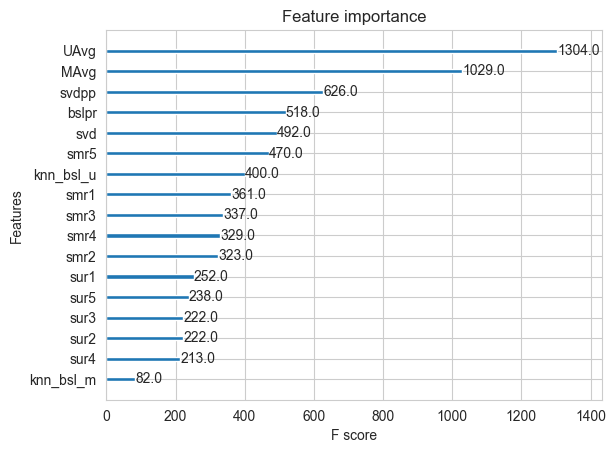

In [193]:
#prepare the train data

x_train = reg_train.drop(['user','movie', 'rating'], axis = 1)
y_train = reg_train['rating']


#prepare the train data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']

params = {'learning_rate' : stats.uniform(0.01, 0.2),
          'n_estimators':sp_randint(100, 1000),
          'max_depth' : sp_randint(1, 10),
          'min_child_weight': sp_randint(1,8),
          'gamma': stats.uniform(0, 0.02),
          'subsample' : stats.uniform(0.6, 0.4),
          'reg_alpha' : sp_randint(0, 200),
          'reg_lambda': stats.uniform(0, 200),
          'colsample_bytree':stats.uniform(0.6, 0.3)
    
}

#Declare xgboost model

xgbreg = xgb.XGBRegressor(silent=True, n_jobs=-1, random_state=15)
start = datetime.now()
print("Tuning parameter\n")
xgb_best = RandomizedSearchCV(xgbreg, param_distributions=params, refit=False, scoring='neg_mean_squared_error',
                              n_jobs=-1, cv=3)

xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_

xgb_knn_bsl = xgbreg.set_params(**best_para)
print('Time taken to tune : {}\n'.format(datetime.now() - start))

train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

#store the results in model_evaluations dictionaries

models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results

xgb.plot_importance(xgb_knn_bsl)
plt.show()

## **Matrix Factorization Techniques**

**SVD Matrix Factorization user movie intractions**

In [194]:
from surprise import SVD

### **Predicting Rating:**

### **Optimazation problem with user item interactios and regularization(to avoid overfitting)**

In [195]:
#initialize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

#just store these error metrics in our models_evaluation datastructure

models_evaluation_train['svd'] = svd_train_results
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Don. time taken : 0:00:02.457276

Evaluating the model with train data...
time taken : 0:00:02.046718
--------------------
Train Data
--------------------
RMSE : 0.95898941200416

MAPE : 29.67947934919099

Adding train results in the dictionary.

Evaluating for test data.
Time taken : 0:00:00.140623
--------------------
Test Data
--------------------
RMSE : 1.0558444267438485

MAPE : 32.187303979197246

Storing the test results in test dictionary.

--------------------------------------------------
Toatl time taken to run this algorithm :  0:00:04.644617


In [196]:
#initialize the model
from surprise import SVDpp
svdpp = SVDpp(n_factors=50, random_state = 15, verbose=True)
svdpp_train_results, svdapp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

#just store these error metrics in our model_evaluation datastructure

models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results



Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Don. time taken : 0:00:48.280998

Evaluating the model with train data...
time taken : 0:00:10.434000
--------------------
Train Data
--------------------
RMSE : 0.9590064708594027

MAPE : 29.589238267225216

Adding train results in the dictionary.

Evaluating for test data.
Time taken : 0:00:00.140848
--------------------
Test Data
--------------------
RMSE : 1.055729254876825

MAPE : 32.184042148202195

Storing the test results in test dictionary.

--------------------------------------------------
Toatl time taken to run this algorithm :  0:00:58.855846


### **SVD Matrix Factorization with implicit feedback from user (user rated movie)**

# **Predictd Rating**

### **Optimization problem  with user item interactions and regularization(to avoid overfitting)**

In [197]:
#initialize the model
svdpp = SVDpp(n_factors = 50, random_state = 15, verbose = True)
svdpp_train_results, svd_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

#

Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Don. time taken : 0:00:48.291602

Evaluating the model with train data...
time taken : 0:00:10.986666
--------------------
Train Data
--------------------
RMSE : 0.9590064708594027

MAPE : 29.589238267225216

Adding train results in the dictionary.

Evaluating for test data.
Time taken : 0:00:00.124955
--------------------
Test Data
--------------------
RMSE : 1.055729254876825

MAPE : 32.184042148202195

Storing the test results in test dictionary.

--------------------------------------------------
Toatl time taken to run this algorithm :  0:00:59.403223


**SVD Matrix factorization with implicit feedback from user(user rated movies)**

### **Predicted Rating:**

### **Optimiazation problem with user item interactions and regularization(to avoid overfitting)**

In [198]:
#initialize  the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdapp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

#just store these error metrics in our model evaluation datastructure

models_evaluation_train['svdpp'] = svdpp_train_results
models_evaluation_test['svdpp'] = svdapp_test_results

Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Don. time taken : 0:00:48.191597

Evaluating the model with train data...
time taken : 0:00:10.488539
--------------------
Train Data
--------------------
RMSE : 0.9590064708594027

MAPE : 29.589238267225216

Adding train results in the dictionary.

Evaluating for test data.
Time taken : 0:00:00.150030
--------------------
Test Data
--------------------
RMSE : 1.055729254876825

MAPE : 32.184042148202195

Storing the test results in test dictionary.

--------------------------------------------------
Toatl time taken to run this algorithm :  0:00:58.830166


## **XgBoost with 13 features and Surprise Baseline, Surprise KNNBaseline and MF techniques**

**Preparing Train data**

In [199]:
#add the predicted values from both knn to this dataframe

reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,1117050,15,3.603745,4.0,3.0,2.0,1.0,1.0,4.0,4.0,...,2.0,4.0,3.222222,2.25,2,3.290466,3.222222,3.222222,3.243475,3.259639
1,1292631,15,3.603745,1.0,1.0,2.0,3.0,4.0,3.0,4.0,...,3.0,3.0,2.313131,2.25,1,3.290466,3.222222,3.222222,3.243475,3.259639
2,1550619,15,3.603745,4.0,2.0,3.0,2.0,1.0,4.0,4.0,...,4.0,4.0,4.000000,2.25,4,3.290466,3.222222,3.222222,3.243475,3.259639
3,1719753,15,3.603745,3.0,4.0,1.0,1.0,2.0,5.0,5.0,...,5.0,4.0,3.785714,2.25,2,3.290466,3.222222,3.222222,3.243475,3.259639
4,1830763,15,3.603745,1.0,3.0,1.0,2.0,2.0,3.0,3.0,...,4.0,4.0,2.978022,2.25,1,3.290466,3.222222,3.222222,3.243475,3.259639


**Preparing test data**

In [200]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,760104,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,...,3.603745,3.603745,3.603745,3.603745,5,3.603745,3.603745,3.603745,3.603745,3.603745
1,777147,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,...,3.603745,3.603745,3.603745,3.603745,5,3.603745,3.603745,3.603745,3.603745,3.603745
2,1451564,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,...,3.603745,3.603745,3.603745,3.603745,5,3.603745,3.603745,3.603745,3.603745,3.603745
3,1496376,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,...,3.603745,3.603745,3.603745,3.603745,1,3.603745,3.603745,3.603745,3.603745,3.603745
4,1748471,5,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,3.603745,...,3.603745,3.603745,3.603745,3.603745,5,3.603745,3.603745,3.603745,3.603745,3.603745


Tuning parameter : 

Time taken to tune:0:07:00.955863

Training the model...
Done. Time taken : 0:00:35.098953

Done

Evaluating the model with train data...
Evaluating test data.

Test Data
--------------------------------------------------
RMSE :  1.101515448530567
MAPE :  30.981881512902397


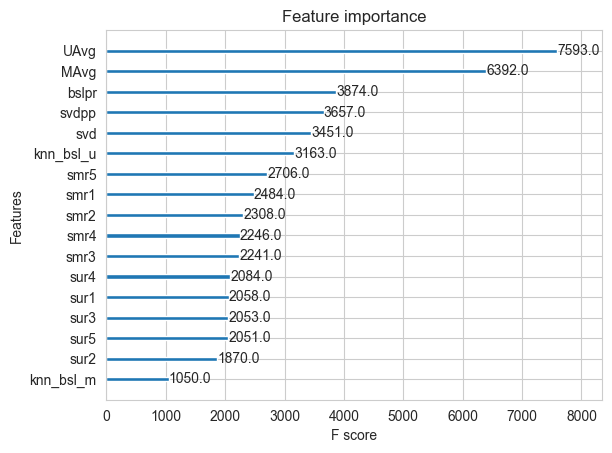

In [201]:
#preparing x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

#prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis = 1)
y_test = reg_test_df['rating']


params = {'learning_rate':stats.uniform(0.01, 0.2),
          'n_estimators':sp_randint(100, 1000),
          'max_depth':sp_randint(1,10),
          'min_child_weight':sp_randint(1, 8),
          'gamma':stats.uniform(0, 0.02),
          'subsample':stats.uniform(0.6, 0.4),
          'reg_alpha':sp_randint(0, 200),
          'reg_lambda':stats.uniform(0, 200),
          'colsample_bytree':stats.uniform(0.6, 0.3)  
}

#Declare XGBoost model..
xgbreg = xgb.XGBRegressor(silent=True, n_jobs=-1, random_state=15)
start = datetime.now()
print("Tuning parameter : \n")

xgb_best = RandomizedSearchCV(xgbreg, param_distributions=params, refit=False, scoring="neg_mean_squared_error",
                              n_jobs = -1, cv = 3)

xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_

xgb_final = xgbreg.set_params(**best_para)
print("Time taken to tune:{}\n".format(datetime.now()-start))

train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

#store the results in the models_evaluation dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results

xgb.plot_importance(xgb_final)
plt.show()

### **XgBoost with Surprise Baseline, Surprise KNNbaseline and MF techniques**

Tuning parameter:

Training the model...
Done. Time taken : 0:00:03.793383

Done

Evaluating the model with train data...
Evaluating test data.

Test Data
--------------------------------------------------
RMSE :  1.071051974348996
MAPE :  31.830646223834442


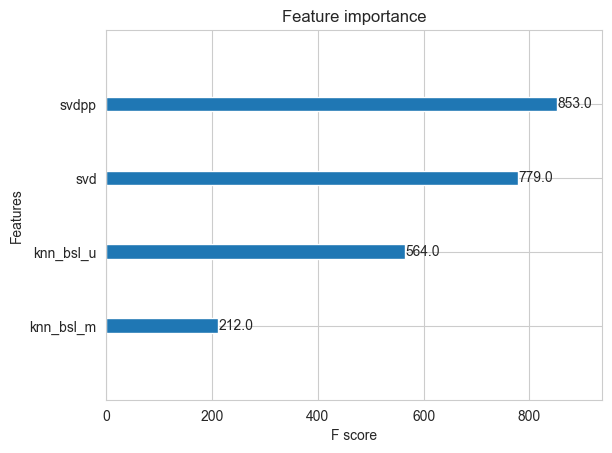

In [202]:
#prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m','svd', 'svdpp']]
y_train = reg_train['rating']

#test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']

params = {'learning_rate':stats.uniform(0.01, 0.2),
          'n_estimators': sp_randint(100, 1000),
          'max_depth':sp_randint(1, 10),
          'min_child_weight':sp_randint(1, 8),
          'gamma':stats.uniform(0, 0.02),
          'subsample':stats.uniform(0.6, 0.4),
          'reg_alpha':sp_randint(0, 200),
          'reg_lambda':stats.uniform(0, 200),
          'colsample_bytree':stats.uniform(0.6, 0.3)
}

#Declare XGBoost model

xgbreg = xgb.XGBRegressor(eval_metricg="neg_mean_squared_error",random_state=42,nthread=-1)
start = datetime.now()

print("Tuning parameter:\n")
xgb_best = RandomizedSearchCV(xgbreg, param_distributions=params, n_jobs=-1, cv = 3)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_

xgb_all_models = xgbreg.set_params(**best_para,some_param = 'sigma__0.2')
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

In [203]:
learning_rate = sp_randint(1, 10)
learning_rate

In [204]:
#prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m','svd', 'svdpp']]
y_train = reg_train['rating']

#test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']

params = {'learning_rate':stats.uniform(0.01, 0.2),
          'n_estimators': sp_randint(100, 1000),
          'max_depth':sp_randint(1, 10),
          'min_child_weight':sp_randint(1, 8),
          'gamma':stats.uniform(0, 0.02),
          'subsample':stats.uniform(0.6, 0.4),
          'reg_alpha':sp_randint(0, 200),
          'reg_lambda':stats.uniform(0, 200),
          'colsample_bytree':stats.uniform(0.6, 0.3)
}

#Declare XGBoost model

xgbreg = xgb.XGBRegressor(eval_metricg="neg_mean_squared_error",random_state=42, nthread=-1)
start = datetime.now()

print("Tuning parameter:\n")
xgb_best = RandomizedSearchCV(xgbreg, param_distributions=params, refit=False, n_jobs=-1, cv = 3)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_



Tuning parameter:



In [205]:
best_para

{'colsample_bytree': 0.7620645917307349,
 'gamma': 0.006728894319860048,
 'learning_rate': 0.034055330011156695,
 'max_depth': 7,
 'min_child_weight': 6,
 'n_estimators': 158,
 'reg_alpha': 154,
 'reg_lambda': 24.522808026901856,
 'subsample': 0.8440688839152793}

Training the model...
Done. Time taken : 0:00:02.656988

Done

Evaluating the model with train data...
Evaluating test data.

Test Data
--------------------------------------------------
RMSE :  1.0633665969122945
MAPE :  31.9844221224731


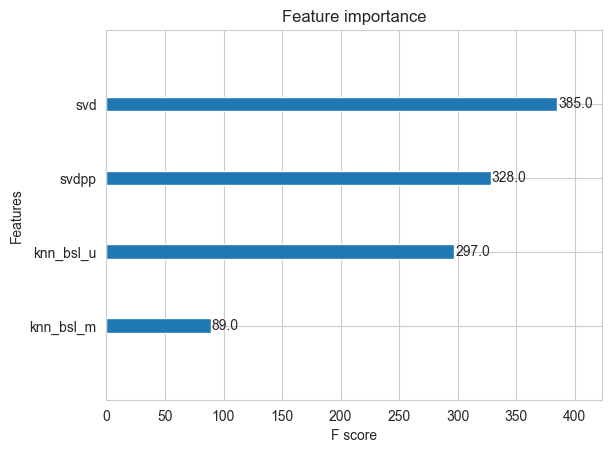

In [206]:
xgb_all_models = xgbreg.set_params(**best_para,some_param = 'sigma__0.2')
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

# **Comparision Between all Models**


### **With tuned Hyperparameter model Performance**

In [207]:
pd.DataFrame(models_evaluation_test).to_csv('tuned_small_sample_results.csv')
models = pd.read_csv('tuned_small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()



bsl_algo          1.0556728510704523
knn_bsl_u         1.0556728510704523
knn_bsl_m         1.0556728510704523
svdpp              1.055729254876825
svd               1.0558444267438485
xgb_all_models    1.0633665969122945
xgb_final          1.101515448530567
xgb_knn_bsl       1.1048392130108293
first_algo        1.1268747969899944
Name: rmse, dtype: object

### **Plot of Train and Test RMSE of tuned Hyperparameter model performance**

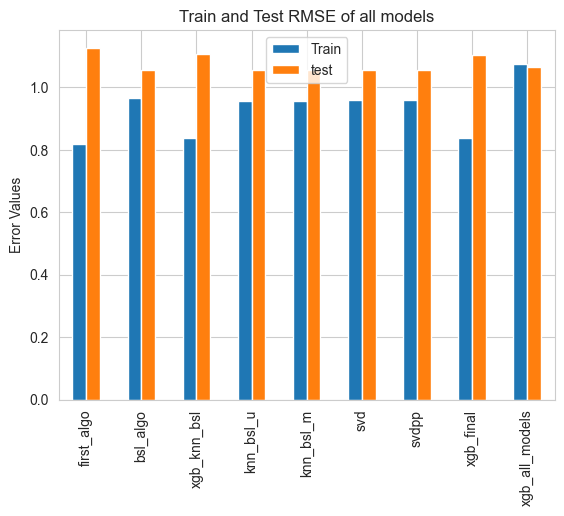

In [208]:
train_performance = pd.DataFrame(models_evaluation_train)
test_performance = pd.DataFrame(models_evaluation_test)

performance_dataframe = pd.DataFrame({'Train': train_performance.loc['rmse'], 'test':test_performance.loc['rmse']})

performance_dataframe.plot(kind='bar', grid=True)
plt.title("Train and Test RMSE of all models")
plt.ylabel("Error Values")
plt.show()

## **Conclusion**



1.  As we know that we have dataset which containes MovieIDs, CustomerIDs, Users.Rating are on a five starscale from 1 to 5 which is integer. Dates formated as yyyy-mm-dd. as we can see that data are given in a different format and we need to make it in one format so that we can apply models on it with users and their rating in a single dataframe.
2.   After doing all that we did EDA on whole dataset like distribution of the ratings, what is the average rating given by users to the movie and all.



3.  After splitting the data into train and test into 80:20 and try EDA on it. And then we are creating MF of user and movie and make it sparseas we can see our data frame is more then 90% sparse which few non zero values are in the matrix. we did it for both train and test data. 

4.   Compute similarity metrices for User-User similarity and movie-movie similarity but as we can see similarity matrix is not very easy(unless we have huge computing Power and lots of time) because of large no. of movie and user.

5.   In above points as we have true to compute similarity but it does not work and after we try some other methods like dim reductions and try to compute but unfortunatly it also does not works and as we can seeit taking more time and memory than our above method due to the dense matrix. so at last we will try to compute similar users for a particular user, whenever requiredfor the particular user/movie. And then we will try to see does it really work? and we just got the awsome results. as we can see we have provide a movie id with movie name Vampire Journals and we got good result which is similar type movie which we provide as input.

6.   After doinglots of work then we worked on different type of machine Learning models and try to compare results of all those but before that we sampled our data because we have lots of data and if we will work with all the data it will take lots of time. so after sampling the data we will do feature engineering which are going to use it as a feature on our ML models.

7.   In this case study we are using Surprise library with parallel to XGBoost models with performance matrix RMSE and MAPE with some hyperparameter tuning on XGBoost.



